<img src='https://www.actris.eu/sites/default/files/inline-images/Actris%20logo.png' width=200 align=right>

# ACTRIS DC 
## Timeseries of Flexpart and measured eBC


In this example, Flexpart model values of Equivalent Black Carbon (eBC) are compared with measured eBC at Birkenes (from the ACTRIS data portal). eBC might exist as a level 3 product in the data portal, if not eBC can be derieved from aerosol light absorption coefficients.

eBC is normally calculated from the absorption coefficient at 637 nm (reference wavelength), divided by the MAC conversion factor. If the measurements do not contain the reference wavelength, it can be calculated from the Ångstøm exponent. 

This example is organized as follows:

(1) &nbsp;&nbsp; Define all python libraries needed

(2) &nbsp;&nbsp;  Specify input files and define variables

(3) &nbsp;&nbsp;  Read Flexpart data and make a simple test plot

(4) &nbsp;&nbsp;  Read Actris data and check the content, e.g., absorption coefficients (abs) 

(5a) &nbsp; Calculate Ångstøm coefficients ($\alpha$) and absorption coefficients at 637nm (if needed)
 
&emsp;&emsp;&emsp;&emsp;  $\alpha=ln(\frac{abs_{470nm}}{abs_{660nm}}) /ln(\frac{660}{470})  $ 

&emsp;&emsp;&emsp;&emsp;  $abs_{637nm}={abs_{660nm}}(\frac{637}{660})^{-\alpha} $ 

&emsp;&emsp;&emsp;&emsp;  Plot the Ångstrøm coefficients as a test

(5b) &nbsp;  Calculate Equivalent Black carbon (eBC)

&emsp;&emsp;&emsp;&emsp;  $eBC_{637nm}=\frac{abs_{637nm}}{MAC_{637nm}}$

(6) &nbsp;&nbsp;  Plot eBC from Flexpart and observations at Birkenes for January 2022



### 1. Libraries 

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import plotly.express as px
import re
import requests
import matplotlib.pyplot as plt
from io import StringIO

### 2. Define file names and variables

In [2]:
# Flexpart file (from ACTRIS data portal, Services: ATMO-ACCESS Flexpart)
Flex_file = 'https://atmo-access.nilu.no/WEBPLOTS/NO0002R/2022/OUT_202201_0/ECMWF/sourcespectrum_TOTAL_BC_a_OUT_202201_0.dat'

# Observation file (from ACTRIS data portal) 
Obs_file = 'https://thredds.nilu.no/thredds/dodsC/ebas_doi/EJ/DP/Q2/EJDP-Q2TQ.nc'

# Constants for calculating eBC
lambda_ref=637.
MAC=10


### 3. Read Flexpart data and make a test plot

    UNIT           START             END    LON      LAT       DOM     ENE  \
0  ng/m3  20220101000000  20220101030000  8.252  58.3885   61.0666  0.6970   
1  ng/m3  20220101030000  20220101060000  8.252  58.3885   53.7575  0.6440   
2  ng/m3  20220101060000  20220101090000  8.252  58.3885   60.0262  0.4901   
3  ng/m3  20220101090000  20220101120000  8.252  58.3885  112.2390  1.6919   
4  ng/m3  20220101120000  20220101150000  8.252  58.3885  207.6163  5.3529   

      FLR     IND     SHP     WST      TRA      BB  
0  3.3214  2.7211  1.2259  0.6013  18.0887  0.2357  
1  1.8844  2.3952  0.9787  0.5738  15.0698  0.2174  
2  2.7140  2.8182  0.9357  0.5451  18.7926  0.1906  
3  3.3914  4.4465  1.3417  0.7622  30.3261  0.2624  
4  3.9969  7.4944  2.9068  1.2733  51.1414  0.2773  


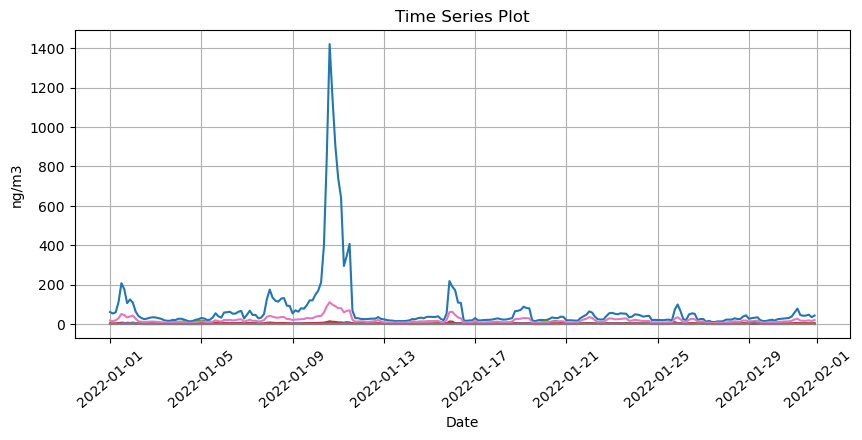

In [3]:
#The following libraries are needed (loaded earlier)
#import requests
#import pandas as pd
#import matplotlib.pyplot as plt
#from io import StringIO

# Flexpart-file (Flex_file) is defined above. Send a GET request to the URL
response = requests.get(Flex_file)

# Check if the request was successful
if response.status_code == 200:
    # Read the content into a pandas DataFrame
    data = StringIO(response.text)
    df = pd.read_csv(data, delim_whitespace=True)
    
    # Display the first few rows to understand its structure
    print(df.head())
    
    # Select date/time column
    time_column = df.columns[1]  
    
    # Convert the time column to datetime
    df[time_column] = pd.to_datetime(df[time_column], format='%Y%m%d%H%M%S')
    
    # Select various eBC sources
    ebc_flexpart = 'eBC_Flexpart'
    value_column1 = df.columns[5]  # DOM
    value_column2 = df.columns[6]  # ENE
    value_column3 = df.columns[7]  # FLR
    value_column4 = df.columns[8]  # IND
    value_column5 = df.columns[9]  # SHP
    value_column6 = df.columns[10]  # WST
    value_column7 = df.columns[11]  # TRA
    value_column8 = df.columns[12]  # BB
    # Total eBC from Flexpart
    df[ebc_flexpart] = df[[value_column1, value_column2, value_column3, value_column4, value_column5, 
                           value_column6, value_column7, value_column8]].sum(axis=1)

    # Plot the time series to check
    plt.figure(figsize=(10, 4))
    plt.plot(df[time_column], df[value_column1])
    plt.plot(df[time_column], df[value_column2])
    plt.plot(df[time_column], df[value_column3])
    plt.plot(df[time_column], df[value_column4])
    plt.plot(df[time_column], df[value_column5])
    plt.plot(df[time_column], df[value_column6])
    plt.plot(df[time_column], df[value_column7])
    plt.plot(df[time_column], df[value_column8])
    #plt.plot(df[time_column], df[ebc_flexpart])
    
    plt.xlabel('Date')
    plt.ylabel('ng/m3')
    plt.title('Time Series Plot')
    plt.xticks(rotation=40)
    plt.grid(True)
    plt.show()

else:
    print(f"Failed to download the file. Status code: {response.status_code}")


### 4. Read ACTRIS data

In [4]:
# Open the dataset 
inst_data = xr.open_dataset(Obs_file) 

#print(inst_data.head()) # Check name of data variables

all_wavelengths = inst_data.Wavelength.values
time=inst_data.time.values 

print("Wavelengths:",all_wavelengths)

# Find the wavelength closest to the reference wavelength and the shortest wavelength
lambda_long = min(all_wavelengths, key=lambda x:abs(x-lambda_ref))
lambda_short = min(all_wavelengths)

print("Wavelength closest to ref:",lambda_long)
print("Shortest wavelength:",lambda_short)


Wavelengths: [470. 522. 660.]
Wavelength closest to ref: 660.0
Shortest wavelength: 470.0


### 5. Calculate Ångstrøm exponent from observations, calculate eBC

c:\Users\tms\AppData\Local\anaconda3\envs\myenv\Lib\site-packages\xarray\core\computation.py:771: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


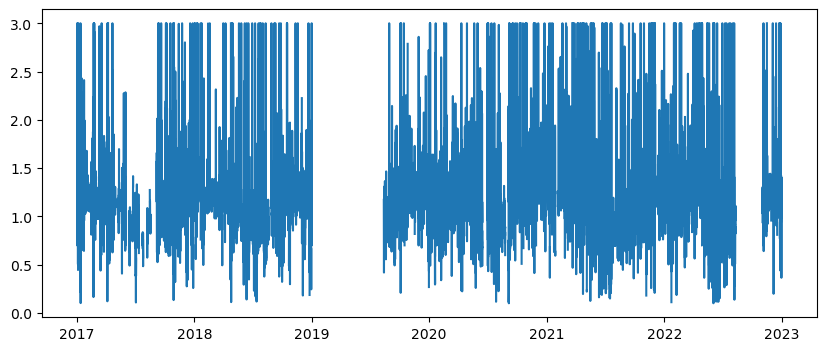

In [5]:
# Select absorption coefficients at two wavelengths defined above
abs_short = inst_data.sel(Wavelength=lambda_short).aerosol_absorption_coefficient_amean
abs_long = inst_data.sel(Wavelength=lambda_long).aerosol_absorption_coefficient_amean

# Create empty arrays with length of dataset
A = len(abs_long)
abs_coeff = np.zeros(A)     #Abs. coeff. at reference wavelength
eBC_ref = np.zeros(A)       #eBC at reference wavelength
alpha = np.zeros(A)         #Ångström exponent

# Calculate Ångström exponent (alpha)
if lambda_long == lambda_ref:
    alpha = 0.0
else:
    alpha = (np.log(abs_short/abs_long)) / (np.log(lambda_long/lambda_short))
    alpha[alpha < 0.1] = 0.7
    alpha[alpha > 3.0] = 3.0
    
    #Plot the Ångström exponent
    plt.figure(figsize=(10, 4))
    plt.plot(time,alpha)


# Calculate absorption coefficient and eBC at reference wavelength
abs_coeff = ((lambda_ref/lambda_long)**(-alpha))*abs_long
eBC_ref = (abs_coeff /MAC).rename('eBC_measured')
#print(abs_coeff.values)


### 6. Plot eBC from observations and Flexpart

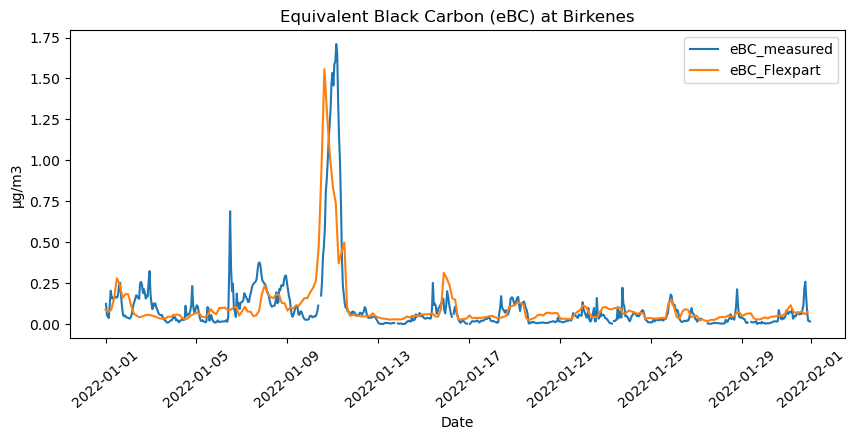

In [6]:

# Convert observations to dataframe and select time period that matches the Flexpart data
df_eBC_ref = eBC_ref.to_dataframe()
df_hour_ref_2022 = df_eBC_ref.eBC_measured['2022-01']
x=df_hour_ref_2022.index[:]

# Plot option 1 (not visible in pdf):
#####################################
# Create station name: a)selct the first part of the name, b)remove non-alphanumeric characters 
station_name_full = inst_data.ebas_station_name
station_string = inst_data.ebas_station_name.split(" ",1)[0]
station_name = re.sub('\W+','', station_string)

# Create plot and save as html file
fig=px.line(df_hour_ref_2022)
fig.add_scatter(x=df[time_column], y=df[ebc_flexpart]/1000, name="eBC_Flexpart", xaxis='x',yaxis='y')
    
fig.update_layout(
    title="Equivalent Black Carbon (eBC) at Birkenes",
    xaxis_title="Time",
    yaxis_title="µg/m3",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="RebeccaPurple"
    ),
)
fig.write_html("timeseries_{0}.html".format(station_name.lower()))
fig.show()    

# Plot option 2:
################
plt.figure(figsize=(10, 4))
plt.plot(x,df_hour_ref_2022, label='eBC_measured')
plt.plot(df[time_column],df[ebc_flexpart]/1000, label='eBC_Flexpart')
plt.xlabel('Date')
plt.ylabel('µg/m3')
plt.title('Equivalent Black Carbon (eBC) at Birkenes')
plt.legend()
plt.xticks(rotation=40)
plt.show()
